# Final Prediction: LightGBM

Train a GBM using K-fold CV and use the mean test prediction across the folds for the final submission.

## Imports

In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Config

Number of CV folds.

In [2]:
NUM_FOLDS = 2

Make subsequent runs reproducible.

In [3]:
RANDOM_SEED = 2017
np.random.seed(RANDOM_SEED)

## Read Data

Load all features we extracted earlier.

In [4]:
df_train = pd.read_csv('../Final_Build/x_train.csv')
df_train.set_index('id', inplace=True)
df_train.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (32,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,q1_hash,q2_hash,q1_freq,q2_freq,PROB_BOTH_SHARE_TOPIC_0,PROB_BOTH_SHARE_TOPIC_1,PROB_BOTH_SHARE_TOPIC_2,PROB_BOTH_SHARE_TOPIC_3,PROB_BOTH_SHARE_TOPIC_4,PROB_BOTH_SHARE_TOPIC_5,...,dist_lcs,dist_qgram,dist_cosine,dist_jaccard,dist_jw,dist_soundex,surplus_intersection,surplus_union,numbers_intersection,numbers_union
id,,,,,,,,,,,,,,,,,,,,,
0,0,290457,1,2,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,...,9,9,0.016396,0.000000,0.045455,0,0.0,0.0,0.0,0.0
1,1,16739,8,3,0.000046,0.000046,0.000046,0.000046,0.000046,0.000046,...,47,41,0.074105,0.296296,0.266241,1,3.0,3.0,0.0,0.0
2,2,290458,2,1,0.000060,0.001250,0.076250,0.000060,0.000060,0.000060,...,60,30,0.048586,0.250000,0.269837,0,0.0,1.0,0.0,0.0
3,3,290459,1,1,0.000125,0.010125,0.000125,0.000125,0.000125,0.007625,...,77,49,0.276068,0.533333,0.423901,1,0.0,0.0,0.0,0.0
4,4,290460,3,1,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,...,63,43,0.104617,0.346154,0.337822,1,0.0,5.0,0.0,0.0


In [5]:
df_test = pd.read_csv('../Final_Build/x_test.csv')
df_test.set_index('test_id', inplace=True)
df_test.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (25,26,27,28,29,30,31,32,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,q1_hash,q2_hash,q1_freq,q2_freq,PROB_BOTH_SHARE_TOPIC_0,PROB_BOTH_SHARE_TOPIC_1,PROB_BOTH_SHARE_TOPIC_2,PROB_BOTH_SHARE_TOPIC_3,PROB_BOTH_SHARE_TOPIC_4,PROB_BOTH_SHARE_TOPIC_5,...,dist_lcs,dist_qgram,dist_cosine,dist_jaccard,dist_jw,dist_soundex,surplus_intersection,surplus_union,numbers_intersection,numbers_union
test_id,,,,,,,,,,,,,,,,,,,,,
0,537361,2680914,1,1,0.000045,0.000045,0.000045,0.000045,0.000045,0.000045,...,67,25,0.068004,0.181818,0.313865,1,0.0,0.0,0.0,1.0
1,537362,1258711,2,2,0.000083,0.001750,0.000083,0.036750,0.000083,0.000083,...,55,31,0.087489,0.217391,0.385600,1,0.0,0.0,0.0,0.0
2,537363,2680915,1,1,0.002625,0.000125,0.000125,0.000125,0.000125,0.000125,...,35,31,0.076901,0.157895,0.314272,1,0.0,0.0,0.0,0.0
3,537364,2680916,1,1,0.000417,0.000417,0.000417,0.008750,0.000417,0.000417,...,20,14,0.140750,0.368421,0.265142,1,0.0,2.0,0.0,0.0
4,537365,2680917,1,1,0.122500,0.000278,0.000278,0.000278,0.000278,0.000278,...,20,14,0.142206,0.222222,0.268056,1,0.0,1.0,0.0,0.0


In [6]:
assert all(df_train.columns == df_test.columns), 'Different cols in train and test'

Drop dodgy index columns

In [7]:
dodgy_cols = df_train.columns[['Unnamed:' in col for col in df_train.columns]].tolist()
df_train.drop(columns=dodgy_cols, inplace=True)
df_test.drop(columns=dodgy_cols, inplace=True)

In [8]:
X_train = df_train.values
X_test = df_test.values

In [9]:
y_train = pd.read_csv('../Final_Build/y_train.csv', header=None).values.reshape(-1, )

View feature summary.

In [10]:
print('X train:', X_train.shape)
print('X test: ', X_test.shape)
print('y train:', y_train.shape)

X train: (404290, 88)
X test:  (2345796, 88)
y train: (404290,)


## Train models & compute test predictions from each fold

Calculate partitions.

In [11]:
kfold = StratifiedKFold(
    n_splits=NUM_FOLDS,
    shuffle=True,
    random_state=RANDOM_SEED
)

Fit all folds.

In [12]:
cv_scores = []

In [13]:
%%time

for fold_num, (ix_train, ix_val) in enumerate(kfold.split(X_train, y_train)):
    print(f'Fitting fold {fold_num + 1} of {kfold.n_splits}')
    
    X_fold_train = X_train[ix_train]
    X_fold_val = X_train[ix_val]

    y_fold_train = y_train[ix_train]
    y_fold_val = y_train[ix_val]
    
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'device': 'cpu',
        'feature_fraction': 0.486,
        'num_leaves': 158,
        'lambda_l2': 50,
        'learning_rate': 0.01,
        'num_boost_round': 5000,
        'early_stopping_rounds': 10,
        'verbose': 1,
        'bagging_fraction_seed': RANDOM_SEED,
        'feature_fraction_seed': RANDOM_SEED,
    }
    
    lgb_data_train = lgb.Dataset(X_fold_train, y_fold_train)
    lgb_data_val = lgb.Dataset(X_fold_val, y_fold_val)    
    evals_result = {}
    
    model = lgb.train(
        lgb_params,
        lgb_data_train,
        valid_sets=[lgb_data_train, lgb_data_val],
        evals_result=evals_result,
        verbose_eval=False,
    )
    
    fold_train_scores = evals_result['training'][lgb_params['metric']]
    fold_val_scores = evals_result['valid_1'][lgb_params['metric']]
    
    print('Fold {}: {} rounds, training loss {:.6f}, validation loss {:.6f}'.format(
        fold_num + 1,
        len(fold_train_scores),
        fold_train_scores[-1],
        fold_val_scores[-1],
    ))
    print()
    
    cv_scores.append(fold_val_scores[-1])
    pickle.dump(model, open('lgbm_model_fold_{}.pkl'.format(fold_num), 'wb'))

Fitting fold 1 of 2


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 1: 3293 rounds, training loss 0.155530, validation loss 0.233951

Fitting fold 2 of 2


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 2: 3299 rounds, training loss 0.156928, validation loss 0.233582

CPU times: user 38min 9s, sys: 34.5 s, total: 38min 43s
Wall time: 10min 46s


In [14]:
importances = pd.DataFrame({
    'column': list(df_train.columns),
    'importance': model.feature_importance(),
}).sort_values(by='importance', ascending=False)

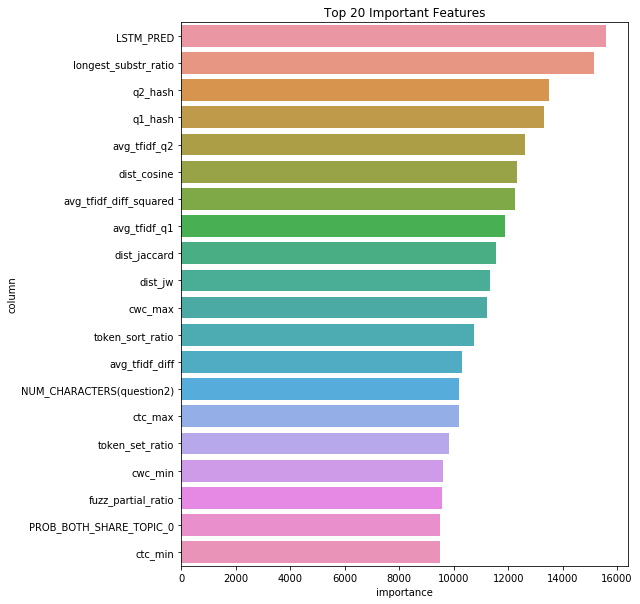

In [15]:
importances_to_plot = importances.iloc[:20, :]

fig, ax = plt.subplots(1, 1, figsize=[8, 10])
sns.barplot(x=importances_to_plot['importance'], y=importances_to_plot['column'], ax=ax)
ax.set_title('Top 20 Important Features')
plt.show()

In [16]:
y_test_pred = np.zeros((len(X_test), NUM_FOLDS))
for fold_num, (ix_train, ix_val) in enumerate(kfold.split(X_train, y_train)):
    model = pickle.load(open('lgbm_model_fold_{}.pkl'.format(fold_num), 'rb'))
    y_test_pred[:, fold_num] = model.predict(X_test).reshape(-1)

Print full feature importance.

In [17]:
importances

,column,importance
74,LSTM_PRED,15610
69,longest_substr_ratio,15144
1,q2_hash,13515
0,q1_hash,13310
49,avg_tfidf_q2,12613
80,dist_cosine,12310
51,avg_tfidf_diff_squared,12254
48,avg_tfidf_q1,11886
81,dist_jaccard,11572
82,dist_jw,11333


In [18]:
final_cv_score = np.mean(cv_scores)

In [19]:
print('Final CV score:', final_cv_score)

Final CV score: 0.23376651739025828


## Generate submission

In [20]:
y_test = np.mean(y_test_pred, axis=1)

In [21]:
submission_id = datetime.datetime.now().strftime('%Y-%m-%d-%H%M')

In [22]:
df_submission = pd.DataFrame({
    'test_id': range(len(y_test)),
    'is_duplicate': y_test
})

### Recalibrate predictions for a different target balance on test

Based on [Mike Swarbrick Jones' blog](https://swarbrickjones.wordpress.com/2017/03/28/cross-entropy-and-training-test-class-imbalance/).

$\alpha = \frac{p_{test}}{p_{train}}$

$\beta = \frac{1 - p_{test}}{1 - p_{train}}$

$\hat{y}_{test}^{\prime} = \frac{\alpha \hat{y}_{test}}{\alpha \hat{y}_{test} + \beta(1 - \hat{y}_{test})}$

Training set balance is 36.92%, test set balance is ~16.5%.

In [23]:
def recalibrate_prediction(pred, train_pos_ratio=0.3692, test_pos_ratio=0.165):
    a = test_pos_ratio / train_pos_ratio
    b = (1 - test_pos_ratio) / (1 - train_pos_ratio)
    return a * pred / (a * pred + b * (1 - pred))

In [24]:
df_submission['is_duplicate'] = df_submission['is_duplicate'].map(recalibrate_prediction)

In [25]:
df_submission = df_submission[['test_id', 'is_duplicate']]

### Explore and save submission

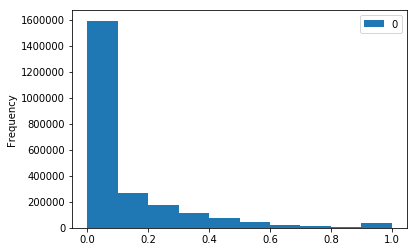

In [26]:
pd.DataFrame(y_test).plot.hist()

In [27]:
print('Test duplicates with >0.9 confidence:', len(df_submission[df_submission.is_duplicate > 0.9]))
print('Test mean prediction:', np.mean(y_test))
print('Calibrated mean prediction:', df_submission['is_duplicate'].mean())

Test duplicates with >0.9 confidence: 30592
Test mean prediction: 0.1139805629399864
Calibrated mean prediction: 0.059992043951665075


In [28]:
df_submission.to_csv(
    'submission.csv',
    header=True,
    float_format='%.8f',
    index=None,
)

In [29]:
df_submission.shape

(2345796, 2)